# I- data ingestion algorithm preparation 

In [1]:
pwd

'c:\\Users\\Amine\\Desktop\\Projects\\cnn_classifier\\research'

In [2]:
import os 
os.chdir("./..")

In [3]:
pwd

'c:\\Users\\Amine\\Desktop\\Projects\\cnn_classifier'

In [ ]:
import os
import urllib.request as request
import zipfile
import tarfile
import time
import concurrent.futures
import smtplib
from base64 import b64encode
from cnnClassifier import logger
from cnnClassifier.constants import *
from cnnClassifier.utils.common_functions import get_size, read_yaml, create_directories
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataIngestionConfig:
    root_dir: Path
    source_URL: str
    local_data_file: Path
    unzip_dir: Path
    auth_method: str
    api_key: str = None
    username: str = None
    password: str = None
    oauth_token: str = None

class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])
    
    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config.data_ingestion
        create_directories([config.root_dir])
        data_ingestion_config = DataIngestionConfig(
            root_dir = config.root_dir,
            source_URL = config.source_URL,
            local_data_file = config.local_data_file,
            unzip_dir = config.unzip_dir
        ) 
        return data_ingestion_config
    
    # def get_data_ingestion_config(self) -> DataIngestionConfig:
    #     config = self.config.data_ingestion
    #     create_directories([config.root_dir])
    #     return DataIngestionConfig(**config)
        
class DataIngestion:
    MAX_RETRIES = 3

    def __init__(self, config: DataIngestionConfig):
        self.config = config

    def authenticate(self):
        headers = {}
        if self.config.auth_method == "api_key":
            headers["Authorization"] = f"Bearer {self.config.api_key}"
        elif self.config.auth_method == "basic_auth":
            credentials = b64encode(f"{self.config.username}:{self.config.password}".encode()).decode()
            headers["Authorization"] = f"Basic {credentials}"
        elif self.config.auth_method == "oauth":
            headers["Authorization"] = f"Bearer {self.config.oauth_token}"
        else:
            raise ValueError("Unsupported authentication method")
        return headers
        
    def download_file(self):
        headers = self.authenticate()
        req = request.Request(self.config.source_URL, headers=headers)
        retries = 0
        while retries < self.MAX_RETRIES:
            try:
                with request.urlopen(req) as response, open(self.config.local_data_file, 'wb') as out_file:
                    out_file.write(response.read())
                break
            except Exception as e:
                retries += 1
                logger.error(f"Error downloading file (Attempt {retries}): {e}")
                time.sleep(5)
        if retries == self.MAX_RETRIES:
            self.notify_failure("Download failed after maximum retries.")

    def extract_file(self):
        try:
            if self.config.local_data_file.endswith('.zip'):
                with zipfile.ZipFile(self.config.local_data_file, "r") as zip_ref:
                    zip_ref.extractall(self.config.unzip_dir)
            elif self.config.local_data_file.endswith('.tar.gz'):
                with tarfile.open(self.config.local_data_file, "r:gz") as tar_ref:
                    tar_ref.extractall(self.config.unzip_dir)
            else:
                logger.warning(f"Unsupported file format: {self.config.local_data_file}")
        except Exception as e:
            logger.error(f"Error extracting file: {e}")
            raise

    def validate_data(self):
        if os.path.getsize(self.config.local_data_file) == 0:
            raise ValueError("Downloaded file is empty")

    def notify_failure(self, message):
        # Email Notification
        with smtplib.SMTP('smtp.example.com', 587) as server:
            server.login("mekki.amine01@gmail.com", "Amine-1963")
            server.sendmail("mekki.amine01@gmail.com", "amineraps@gmail.com", message)



# II- Prepare base model

In [1]:
from PIL import Image

img_path = "./../artifacts/data_ingestion/g1.jpeg"
img = Image.open(img_path)

num_channels = len(img.split())

print(f"The image has {num_channels} channel(s).")


The image has 3 channel(s).


In [2]:
import torch.nn as nn

class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()
        
        # Define blocks with convolutional layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

model = VGG19()


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from sklearn.metrics import precision_score, recall_score, f1_score

def load_data(train_dir, test_dir, val_split=0.2, subset_percent=1, batch_size=32, num_workers=4):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    full_train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    
    n_train_samples = int(subset_percent * len(full_train_dataset))
    n_val_samples = len(full_train_dataset) - n_train_samples

    train_dataset, val_dataset = random_split(full_train_dataset, [n_train_samples, n_val_samples])
    
    train_dataset.classes = full_train_dataset.classes
    val_dataset.classes = full_train_dataset.classes
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        train_predictions, train_targets = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_predictions.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(train_targets, train_predictions)

        # Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        val_predictions, val_targets = [], []

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_predictions.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss = running_loss / len(validation_loader.dataset)
        val_accuracy, val_precision, val_recall, val_f1 = compute_metrics(val_targets, val_predictions)

        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} Precision: {train_precision:.4f} Recall: {train_recall:.4f} F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f}')
        print('-' * 10)

    return model


def predict(model, test_loader, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
    
    return all_predictions


def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

def visualize_images(dataloader, num_images=4):
    """Visualize a batch of images."""
    dataiter = iter(dataloader)
    
    try:
        inputs, classes = next(dataiter)
    except StopIteration:
        print("Dataloader is exhausted.")
        return
    inputs, classes = inputs[:num_images], classes[:num_images]  # Select the number of images you want

    out = torchvision.utils.make_grid(inputs)
    
    class_names = dataloader.dataset.classes
    imshow(out, title=[class_names[x] for x in classes])



def compute_metrics(targets, predictions):
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    accuracy = (predictions == targets).sum() / len(targets)
    precision = precision_score(targets, predictions, average='macro', zero_division=1)
    recall = recall_score(targets, predictions, average='macro')
    f1 = f1_score(targets, predictions, average='macro')
    
    return accuracy, precision, recall, f1



In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = './../artifacts/data_ingestion//Training'
test_dir = './../artifacts/data_ingestion/Testing'

train_loader, val_loader, test_loader = load_data(train_dir, test_dir, val_split=0.2, subset_percent=1, batch_size=16, num_workers=4)


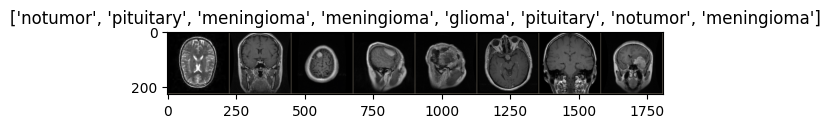

In [34]:
visualize_images(train_loader, 8)

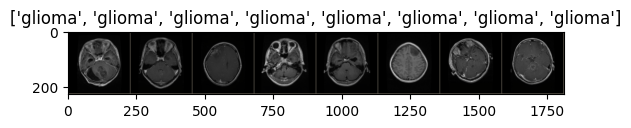

In [35]:
visualize_images(test_loader, 8)

In [36]:
# Number of samples
num_samples = len(train_loader.dataset)
print(f"Number of samples in the training loader: {num_samples}")

# Size of the samples
images, labels = next(iter(train_loader))
image_size = images.size()
print(f"Size of the images: {image_size}")

Number of samples in the training loader: 5712
Size of the images: torch.Size([16, 3, 224, 224])


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [39]:
train_model(model, criterion, optimizer, train_loader, val_loader, 25)


KeyboardInterrupt: 

# use pretraiend models

In [6]:
pwd

'c:\\Users\\Amine\\Desktop\\Projects\\cnn_classifier\\research'

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from dataclasses import dataclass
from torchsummary import summary
from pathlib import Path
from cnnClassifier.constants import *
from cnnClassifier.utils.common_functions import read_yaml, create_directories



@dataclass(frozen=True) 
class PrepareBaseModelConfig:
    root_dir : Path
    base_model_path : Path
    updated_base_model_path : Path
    params_image_size : list 
    params_learning_rate : float 
    params_include_top : bool
    params_weights : str
    params_classes : int

In [2]:
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])
    
    def get_prepare_base_model_config(self) -> PrepareBaseModelConfig:
        config = self.config.prepare_base_model
        create_directories([config.root_dir])
        
        prepare_base_model_config = PrepareBaseModelConfig(
            root_dir = Path(config.root_dir),
            base_model_path = Path(config.base_model_path),
            updated_base_model_path = Path(config.updated_base_model_path),
            params_image_size = self.params.IMAGE_SIZE,
            params_learning_rate = self.params.LEARNING_RATE,
            params_include_top = self.params.INCLUDE_TOP,
            params_weights = self.params.WEIGHTS,
            params_classes = self.params.CLASSES
            
        )
        
        return prepare_base_model_config

In [7]:
class PrepareBaseModel:
    def __init__(self, config: PrepareBaseModelConfig):
        self.config = config

    def get_base_model(self):
        # Note: torchvision has pre-trained weights only for include_top=True. So if you need exclude top, you'll need to handle that differently.
        self.model = models.vgg19(pretrained=(self.config.params_weights == "imagenet"))

        if not self.config.params_include_top:
            # Removing the classifier part
            self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.save_model(path=self.config.base_model_path, model=self.model)

    def _prepare_full_model(self, model, classes, freeze_all, freeze_till, learning_rate):
        if freeze_all:
            for param in model.parameters():
                param.requires_grad = False
        elif (freeze_all is not None) and (freeze_all > 0):
            ct = 0
            for child in model.children():
                ct += 1
                if ct < freeze_till:
                    for param in child.parameters():
                        param.requires_grad = False

        # If include_top is False
        if not self.config.params_include_top:
            # Adding new layers
            model = nn.Sequential(
                model,
                nn.Flatten(),
                nn.Linear(512 * 7 * 7, classes)  # This assumes the standard output size of VGG19 before classifier. Adjust if necessary.
            )
        else:
            # Adjusting existing classifier for different number of classes
            num_ftrs = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_ftrs, classes)

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        return model

    def update_base_model(self):
        self.full_model, optimizer, criterion = self._prepare_full_model(
            model=self.model,
            classes=self.config.params_classes,
            freeze_all=True,
            freeze_till=None,
            learning_rate=self.config.params_learning_rate
        )
        self.save_model(path=self.config.updated_base_model_path, model=self.full_model)

    @staticmethod
    def save_model(path: Path, model:nn.Module):
        torch.save(model.state_dict(), path)
    
    def get_summary(self, input_size):
        return summary(self.full_model, input_size)


In [11]:

config_manager = ConfigurationManager()
prepare_base_model_config = config_manager.get_prepare_base_model_config()
prepare_base_model = PrepareBaseModel(prepare_base_model_config)
prepare_base_model.get_base_model()  # Assuming you meant this function instead of `get_base_model()`
prepare_base_model.update_base_model()
correct_input_size = tuple(prepare_base_model_config.params_image_size[-1:] + prepare_base_model_config.params_image_size[:-1])
print(prepare_base_model.get_summary(input_size=correct_input_size))

[ 2023-09-02 01:31:31,121 ] 40 cnnClassifier - INFO - Yaml file : ..\config\config.yaml loaded successfully.
[ 2023-09-02 01:31:31,123 ] 40 cnnClassifier - INFO - Yaml file : ..\params.yaml loaded successfully.
[ 2023-09-02 01:31:31,124 ] 62 cnnClassifier - INFO - created directory at : artifacts
[ 2023-09-02 01:31:31,125 ] 62 cnnClassifier - INFO - created directory at : artifacts\prepare_base_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-

## 03 prepare callback

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from dataclasses import dataclass
from torchsummary import summary
from pathlib import Path
from cnnClassifier.constants import *
from cnnClassifier.utils.common_functions import read_yaml, create_directories
from zipfile import ZipFile
from torch.utils.tensorboard import SummaryWriter

@dataclass(frozen=True)
class PrepareCallbackConfig:
    root_dir : Path
    tensorboard_root_log_dir = Path
    checkpoint_model_filepath : Path

In [12]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])
    
    def get_prepare_callback_config(self) -> PrepareCallbackConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])
        
        prepare_callback_config = PrepareCallbackConfig(
            root_dir = Path(config.root_dir),
            tensorboard_root_log_dir = Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath = Path(config.checkpoint_model_filepath)
        )
        
        return prepare_callback_config
        
    

In [14]:
# component


class PrepareCallback:
    def __init__(self, config = PrepareCallbackConfig):
        self.config = config
    
    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}"
        )
        return SummaryWriter(log_dir=tb_running_log_dir)

    @property
    def _create_ckpt_callbacks(self, model, optimizer, epoch, loss):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, self.config.checkpoint_model_filepath)

        
    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]



In [15]:
# test 

try : 
    config_manager = ConfigurationManager()
    prepare_callback_config = config_manager.get_prepare_callback_config()
    prepare_callback = PrepareCallback(prepare_callback_config)
    prepare_callback.get_tb_ckpt_callbacks()
    
except Exception as e:
    print(e)

[ 2023-09-12 20:24:42,002 ] 40 cnnClassifier - INFO - Yaml file : config\config.yaml loaded successfully.
[ 2023-09-12 20:24:42,018 ] 40 cnnClassifier - INFO - Yaml file : params.yaml loaded successfully.
[ 2023-09-12 20:24:42,020 ] 62 cnnClassifier - INFO - created directory at : artifacts
[ 2023-09-12 20:24:42,022 ] 62 cnnClassifier - INFO - created directory at : artifacts\prepare_callbacks\checkpoint_dir
[ 2023-09-12 20:24:42,023 ] 62 cnnClassifier - INFO - created directory at : artifacts\prepare_callbacks\tensorboard_log_dir
PrepareCallbackConfig.__init__() got an unexpected keyword argument 'tensorboard_root_log_dir'


# 04 model trainer 
